Link to Assignment document:

https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/02-regression/homework.md

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as pyplot
%matplotlib inline

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
selection = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
df = df[selection]

In [3]:
def quick_look(mydf, m=5):
    print(f"It is in type of {type(mydf)} and shape of {mydf.shape}")
    for col in df.columns:
        print(str(col).upper(), 
            f"column has {mydf[col].nunique()} unique values (in {mydf[col].dtypes} format) and {mydf[col].isnull().sum()} NaNs")
        print(mydf[col].unique()[:m], "\n")

quick_look(df, 5)

It is in type of <class 'pandas.core.frame.DataFrame'> and shape of (48895, 8)
LATITUDE column has 19048 unique values (in float64 format) and 0 NaNs
[40.64749 40.75362 40.80902 40.68514 40.79851] 

LONGITUDE column has 14718 unique values (in float64 format) and 0 NaNs
[-73.97237 -73.98377 -73.9419  -73.95976 -73.94399] 

PRICE column has 674 unique values (in int64 format) and 0 NaNs
[149 225 150  89  80] 

MINIMUM_NIGHTS column has 109 unique values (in int64 format) and 0 NaNs
[ 1  3 10 45  2] 

NUMBER_OF_REVIEWS column has 394 unique values (in int64 format) and 0 NaNs
[  9  45   0 270  74] 

REVIEWS_PER_MONTH column has 937 unique values (in float64 format) and 10052 NaNs
[0.21 0.38  nan 4.64 0.1 ] 

CALCULATED_HOST_LISTINGS_COUNT column has 47 unique values (in int64 format) and 0 NaNs
[6 2 1 4 3] 

AVAILABILITY_365 column has 366 unique values (in int64 format) and 0 NaNs
[365 355 194   0 129] 



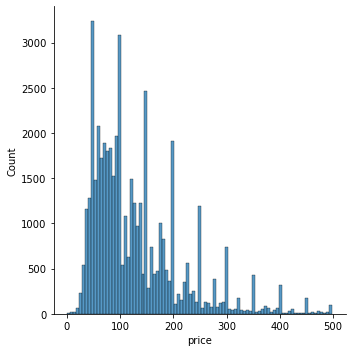

In [4]:
sns.displot(df['price'][df['price']<500])

# Q1

number_of_reviews: 10052

# Q2

In [5]:
print( df["minimum_nights"].median() )

3.0


# Q3

In [6]:
df_org = df.copy()
print(df.shape) # check the current shape
price = np.log1p(df['price'])
del df['price']
print(df.shape) # check the final shape
print(price.tail())  # see price

(48895, 8)
(48895, 7)
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: price, dtype: float64


In [7]:
def split_df(my_df, len_train=60, len_val=20, len_test=20, seed=42):
    """The function splits a DataFrame into train, validation and 
    test parts using the given portions(%).
    !!! If you drop target valuable before splitting, take care 
    using same seed value both for the main body and target column"""

    n = len(my_df)
    n_val = int(n * (len_val/(len_train+len_val+len_test)))
    n_test = int(n * (len_test/(len_train+len_val+len_test)))
    n_train = n - n_val - n_test
    #print("Length of train, validation and test parts:", n_train, n_val, n_test)
    
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    my_df_train = my_df.iloc[idx[:n_train]]
    my_df_val = my_df.iloc[idx[n_train:n_train+n_val]]
    my_df_test = my_df.iloc[idx[n_train+n_val:]]

    my_df_train = my_df_train.reset_index(drop=True)
    my_df_val = my_df_val.reset_index(drop=True)
    my_df_test = my_df_test.reset_index(drop=True)

    return my_df_train, my_df_val, my_df_test



In [8]:
df_train, df_val, df_test = split_df(df)
price_train, price_val, price_test = split_df(price)

# Instead one can devide the DataFrame into train, validation and test parts 
# with target column and then seperate them as main body and target column. 

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [10]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [11]:
# Computations for filling with zero

df_train_zero = df_train.copy().fillna(0)
price_train_zero = price_train.copy().fillna(0)

df_val_zero = df_val.copy().fillna(0)
price_val_zero = price_val.copy().fillna(0).values

w0_zero, w_zero = train_linear_regression(df_train_zero.values, price_train_zero.values)
print(w0_zero, w_zero)

price_pred_zero = w0_zero + df_val_zero.dot(w_zero)
rmse(price_val_zero, price_pred_zero).round(2)

-419.91265872315813 [ 1.30676225e+00 -5.02167855e+00 -5.59803110e-04 -4.07634897e-04
 -8.25470065e-03  1.33371320e-03  6.50203890e-04]


0.64

In [12]:
# Computations for filling with mean

mean = df_train['reviews_per_month'].mean()

df_train_mean = df_train.copy().fillna(mean)
price_train_mean = price_train.copy().fillna(mean)

df_val_mean = df_val.copy().fillna(mean)
price_val_mean = price_val.copy().fillna(mean).values

w0_mean, w_mean = train_linear_regression(df_train_mean.values, price_train_mean.values)

price_pred_mean = w0_mean + df_val_mean.dot(w_mean)
rmse(price_val_mean, price_pred_mean).round(2)

0.64

# Q4

In [13]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [14]:
df_train_zero = df_train.copy().fillna(0)
price_train_zero = price_train.copy().fillna(0)

df_val_zero = df_val.copy().fillna(0)
price_val_zero = price_val.copy().fillna(0).values

r_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in r_list:
    w0_zero, w_zero = train_linear_regression_reg(df_train_zero.values, price_train_zero.values, r)
    price_pred_zero = w0_zero + df_val_zero.dot(w_zero)
    r_rmse= rmse(price_val_zero, price_pred_zero).round(2)
    print(r_rmse)

0.64
0.64
0.64
0.64
0.66
0.68
0.68
0.68
0.68


# Q5

In [15]:
def seed_test(my_df, target_col,seed_list):
    result = []
    for i in seed_list:
        y = np.log1p(my_df[target_col].copy())
        X = my_df.drop([target_col], axis=1).copy()
        y_train, y_val, y_test = split_df(y, 60, 20, 20, i)
        X_train, X_val, X_test = split_df(X, 60, 20, 20, i)

        X_train = X_train.fillna(0)
        y_train = y_train.fillna(0)
        X_val = X_val.fillna(0).values
        y_val = y_val.fillna(0).values

        w0, w = train_linear_regression(X_train.values, y_train.values)
        y_pred = w0 + X_val.dot(w)
        err = rmse(y_val, y_pred)
        result.append(err)
    return result
 

In [16]:
test_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

result_list = seed_test(df_org, 'price', test_list)

round(np.std(result_list),3)


0.008

# Q6

In [17]:
df2 = df_org.copy()

y = np.log1p(df2["price"].copy())
X = df2.drop(["price"], axis=1).copy()

y_train, y_val, y_test = split_df(y, 80, 0, 20, 9)
X_train, X_val, X_test = split_df(X, 80, 0, 20, 9)

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
#X_val = X_val.fillna(0).values
#y_val = y_val.fillna(0).values

X_test = X_test.fillna(0)
y_test = y_test.fillna(0).values


w0, w = train_linear_regression_reg(X_train.values, y_train.values, 0.001)

y_pred = w0 + X_test.dot(w)


err = rmse(y_test, y_pred)
print(err)

0.6452771348506992
